In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython import display

from DLHelperFunctions import *

import librosa.display
import librosa
import soundfile as sf

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

2022-10-20 16:49:38.531254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# Set the dataset path
OPUS_DATASET_PATH = './data/mswc_microset/'
WAV_DATASET_PATH = './data/mswc_microset_wav/'
TRIMD_DATASET_PATH = './data/mswc_microset_trimd/'

# Download the dataset
opus_dir = pathlib.Path(OPUS_DATASET_PATH)
wav_dir = pathlib.Path(WAV_DATASET_PATH)
trimd_dir = pathlib.Path(TRIMD_DATASET_PATH)
if not opus_dir.exists():
    tf.keras.utils.get_file(
        'mswc_microset.tar.gz',
        origin="https://storage.googleapis.com/public-datasets-mswc/mswc_microset.tar.gz",
        extract=True,
        cache_dir='.', cache_subdir='data')

In [4]:
# Convert OPUS to WAV & Reformat the directories
wav_ds = os.path.join(wav_dir, 'clips/')

if not os.path.exists(wav_dir):
    os.makedirs(wav_dir)
    if not os.path.exists(wav_ds):
        os.makedirs(wav_ds)

    en_opus_path = os.path.join(opus_dir, 'en/clips/')
    es_opus_path = os.path.join(opus_dir, 'es/clips/')

    opus_to_wav(en_opus_path, wav_ds)
    opus_to_wav(es_opus_path, wav_ds)

In [5]:
# Trim Audio of silence and store
trmd_ds = os.path.join(trimd_dir, 'clips/')

if not os.path.exists(trimd_dir):
    os.makedirs(trimd_dir)
    if not os.path.exists(trmd_ds):
        os.makedirs(trmd_ds)

    for word in os.listdir(wav_ds):
        wav_word_path = os.path.join(wav_ds, word)
        print("Trimming WAVs of \"" + word + "\" class")
        print('++++++++++++++++++++++++++++++++++')
        new_wav_word_path = os.path.join(trmd_ds, word)
        os.makedirs(new_wav_word_path)
        for wav in os.listdir(wav_word_path):
            cur_wav = os.path.join(wav_word_path, wav)
            new_cur_wav = os.path.join(new_wav_word_path, "t_" + wav)
            t_wav, sr = trim_audio(cur_wav)
            #open(os.path.join(trmd_ds, t_name), 'a').close()
            sf.write(new_cur_wav, t_wav, sr, format='wav')
    print('DONE!')

In [6]:
# Print the Classification Commands of the Dataset
#words = np.array(tf.io.gfile.listdir(wav_ds))
words = np.array(tf.io.gfile.listdir(trmd_ds))
words = np.sort(words)
print('Words:', words)

Words: ['en-backward' 'en-bed' 'en-bird' 'en-down' 'es-tiempo' 'es-tres'
 'es-universidad' 'es-uno' 'es-vida']


In [7]:
sr = 20000
#sr = 45000

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    #directory=wav_ds,
    directory=trmd_ds,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=sr,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 116215 files belonging to 48 classes.
Using 92972 files for training.
Using 23243 files for validation.

label names: ['en-backward' 'en-bed' 'en-bird' 'en-down' 'en-eight' 'en-five'
 'en-follow' 'en-forward' 'en-four' 'en-house' 'en-learn' 'en-left'
 'en-marvin' 'en-nine' 'en-off' 'en-one' 'en-right' 'en-seven' 'en-sheila'
 'en-six' 'en-stop' 'en-three' 'en-tree' 'en-two' 'en-visual' 'en-wow'
 'en-yes' 'en-zero' 'es-canción' 'es-cero' 'es-cinco' 'es-ciudad'
 'es-color' 'es-cuatro' 'es-dos' 'es-encuentra' 'es-juego' 'es-nombre'
 'es-nueve' 'es-número' 'es-ocho' 'es-seis' 'es-siete' 'es-tiempo'
 'es-tres' 'es-universidad' 'es-uno' 'es-vida']


2022-10-20 16:49:43.520382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 16:49:43.832877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21386 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0c:00.0, compute capability: 8.6


In [8]:
train_ds.element_spec

(TensorSpec(shape=(None, 20000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [9]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [10]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [11]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 20000)
(64,)


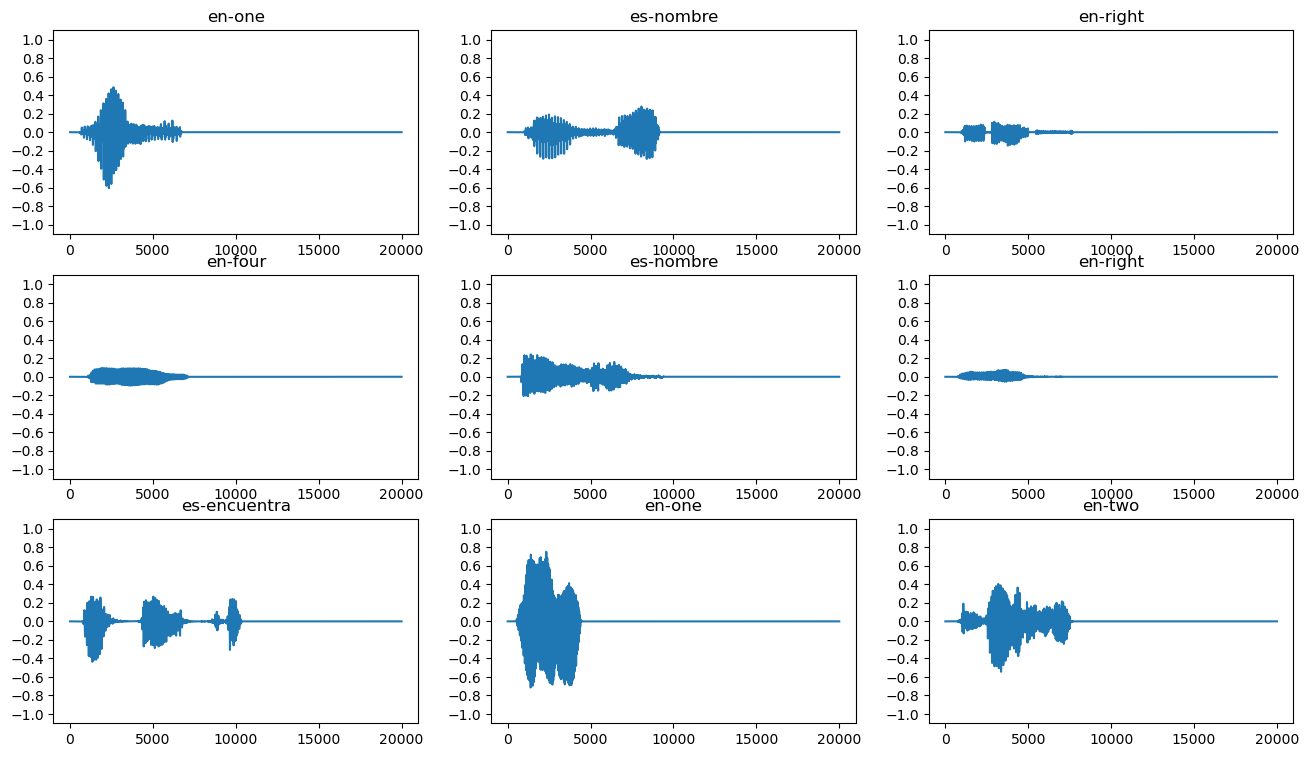

In [12]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [13]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=sr))

Label: en-one
Waveform shape: (20000,)
Spectrogram shape: (155, 129, 1)
Audio playback


Label: es-nombre
Waveform shape: (20000,)
Spectrogram shape: (155, 129, 1)
Audio playback


Label: en-right
Waveform shape: (20000,)
Spectrogram shape: (155, 129, 1)
Audio playback


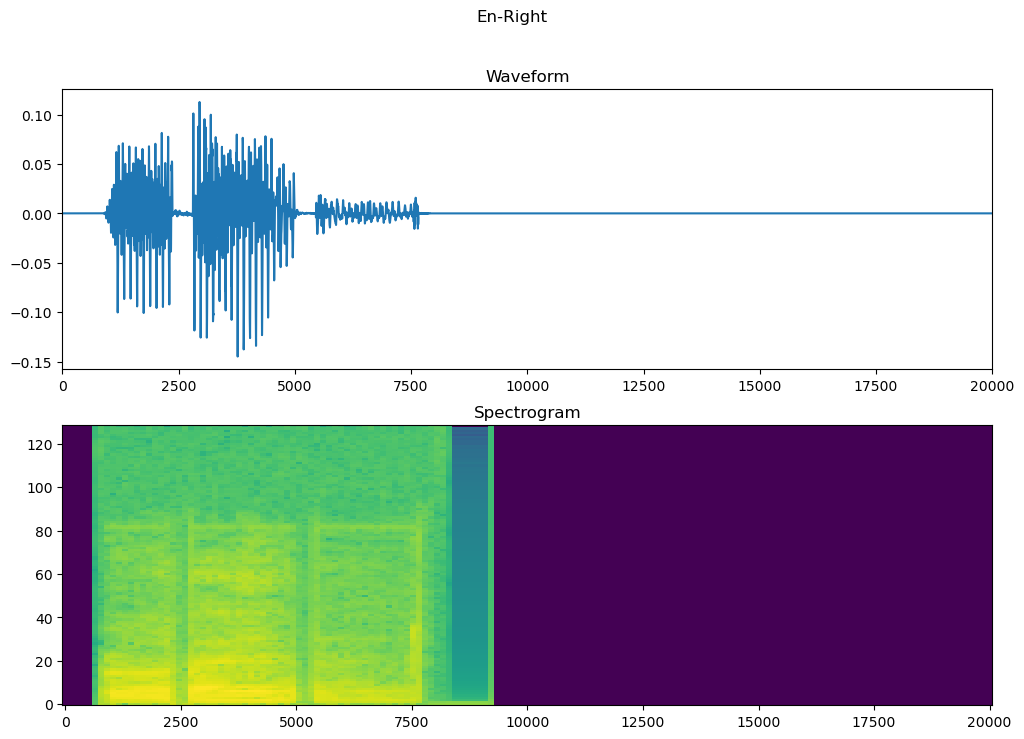

In [14]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, sr])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [15]:
# Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model
train_ds = train_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [16]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

# train_spectrogram_ds = make_melspec_ds(train_ds,sr)
# val_spectrogram_ds = make_melspec_ds(val_ds,sr)
# test_spectrogram_ds = make_melspec_ds(test_ds,sr)

# train_spectrogram_ds = train_spectrogram_ds.concatenate(make_melspec_ds(train_ds,sr))
# val_spectrogram_ds = val_spectrogram_ds.concatenate(make_melspec_ds(val_ds,sr))
# test_spectrogram_ds = test_spectrogram_ds.concatenate(make_melspec_ds(test_ds,sr))

# train_spectrogram_ds = train_spectrogram_ds.concatenate(make_melspec_db(train_ds,sr))
# val_spectrogram_ds = val_spectrogram_ds.concatenate(make_melspec_db(val_ds,sr))
# test_spectrogram_ds = test_spectrogram_ds.concatenate(make_melspec_db(test_ds,sr))

# train_spectrogram_ds = train_spectrogram_ds.concatenate(make_mfcc_ds(train_ds,sr))
# val_spectrogram_ds = val_spectrogram_ds.concatenate(make_mfcc_ds(val_ds,sr))
# test_spectrogram_ds = test_spectrogram_ds.concatenate(make_mfcc_ds(test_ds,sr))

# train_spectrogram_ds = make_four_ds(train_ds,sr)
# val_spectrogram_ds = make_four_ds(val_ds,sr)
# test_spectrogram_ds = make_four_ds(test_ds,sr)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

IndexError: index 25 is out of bounds for axis 0 with size 9

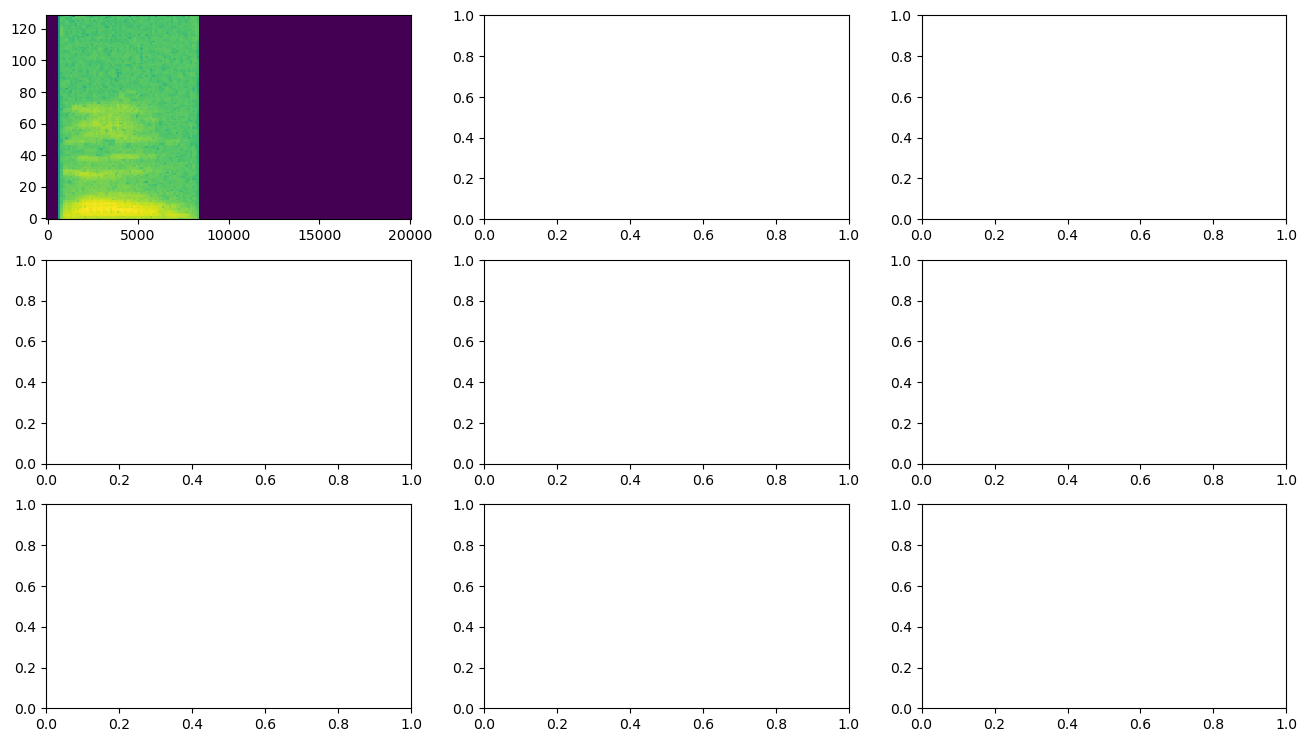

In [18]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(words[example_spect_labels[i].numpy()])

plt.show()

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(words)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

In [ ]:
y_pred = model.predict(test_spectrogram_ds)

In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 18))
sns.heatmap(confusion_mtx,
            xticklabels=words,
            yticklabels=words,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
x = 'data/inference_samples/wow_sample.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=sr,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
plt.figure(figsize=(60,10))
plt.bar(words, tf.nn.softmax(prediction[0]))
plt.title('Wow')
plt.show()


display.display(display.Audio(waveform, rate=sr))

In [ ]:
# Save model in "./saved"
model.save("saved_trmd")